In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
import pandas as pd
import scipy
import scipy.stats
from datetime import datetime, timedelta
from mycolorpy import colorlist as mcp
from matplotlib import colors as mcolors
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

import ginipy
import plots
import feature_selection

# Preparing the data

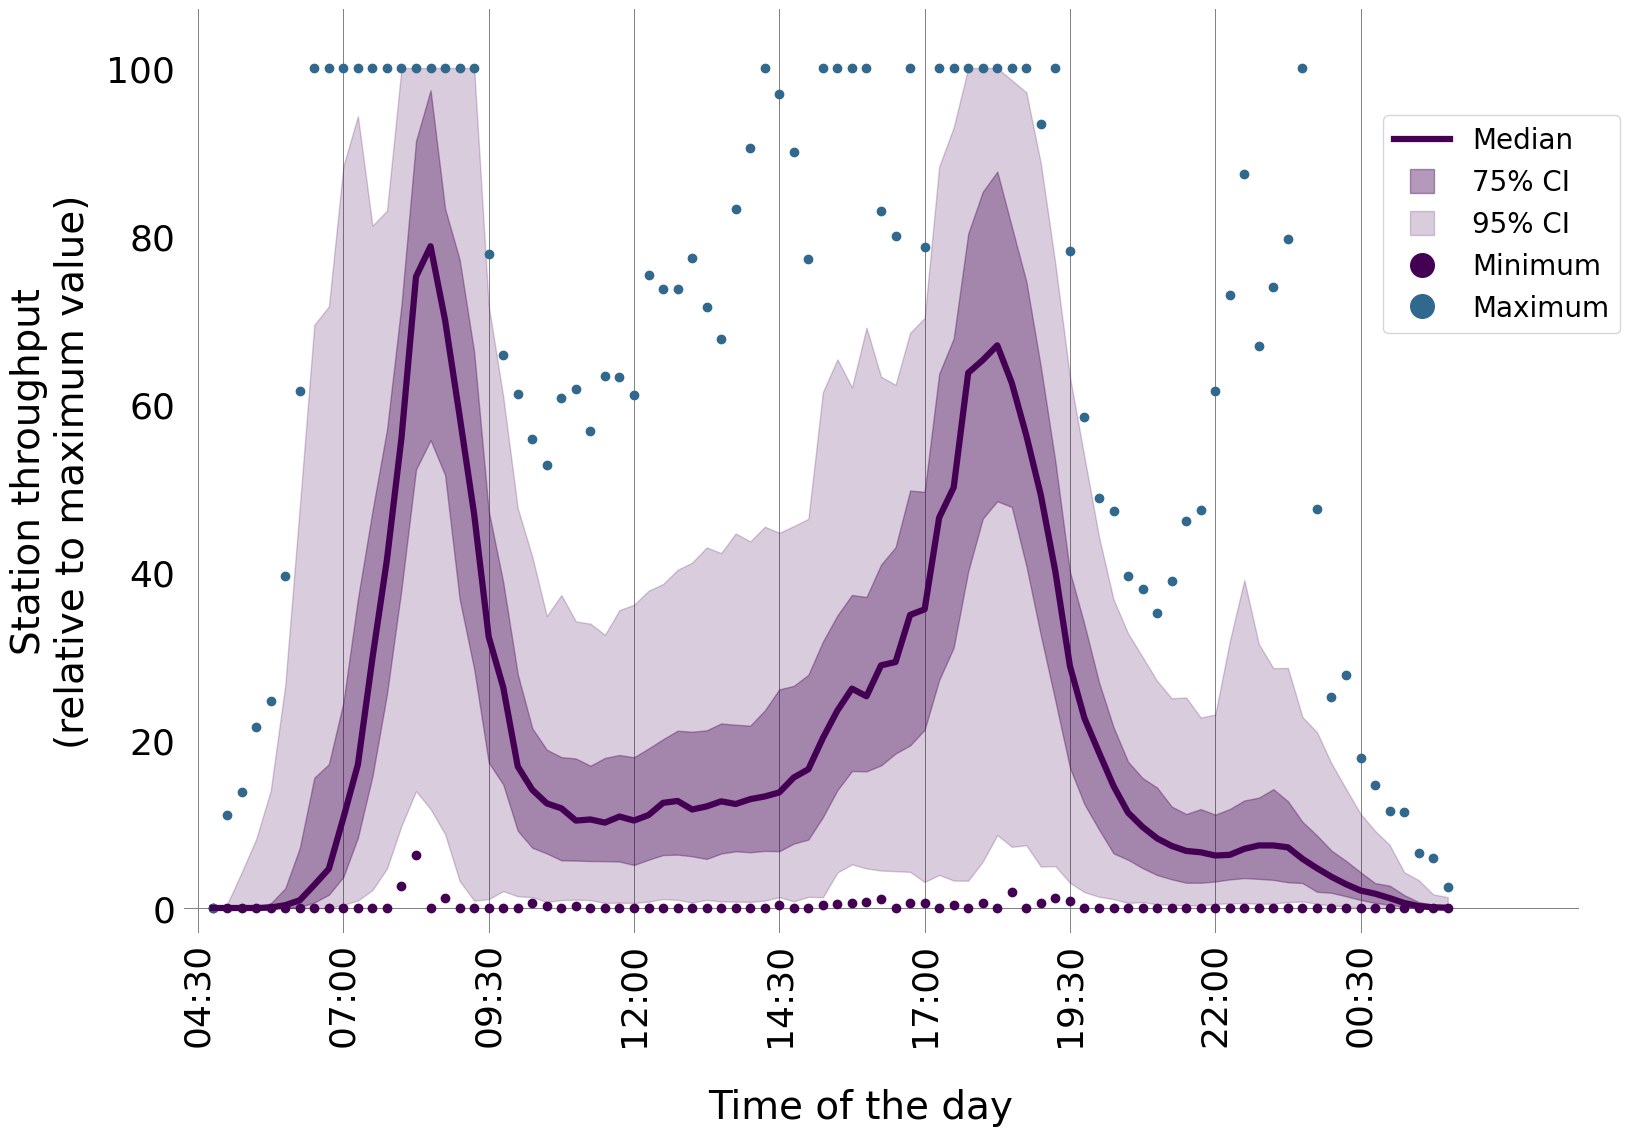

In [3]:
# Load relevant data sets (daily throughput for individual stations and aggregate)
df_stn_ts = pd.read_csv('outputs/stn_data/demand/stn_ts_throughput.csv')
df_agg_ts = pd.read_csv('outputs/stn_data/demand/agg_ts_throughput.csv')
# Load relevant data sets (daily entries and exits for individual stations, will be relevant for the clustering section)
df_stn_ts_entry = pd.read_csv('outputs/stn_data/demand/stn_ts_entry.csv')
df_stn_ts_entry = df_stn_ts_entry.rename({'EntryStationName': 'StationName'}, axis=1)
df_stn_ts_exit = pd.read_csv('outputs/stn_data/demand/stn_ts_exit.csv')
df_stn_ts_exit = df_stn_ts_exit.rename({'ExitStationName': 'StationName'}, axis=1)

# Sort stations by total throughput
throughput = [np.sum(df_stn_ts.iloc[i,1:]) for i in range(len(df_stn_ts))]
df_stn_ts['Daily throughput'] = throughput
df_stn_ts = df_stn_ts.sort_values(by='Daily throughput', ascending=True).reset_index(drop=True)
throughput = np.array(df_stn_ts['Daily throughput']).astype('float64')

# Create lists of 15-min interval for entire day
today = pd.to_datetime('today').date()
entrytime_start = list(pd.date_range(today, today+timedelta(days=1), freq='15T').strftime('%H:%M'))

# Keep intervals from 04:30 (18th interval) to 01:45 (7th interval)
entrytime_start = entrytime_start[18:-1] + entrytime_start[:8]

# Create dataframe
df_time = pd.DataFrame(list(zip(entrytime_start,list(range(1,len(entrytime_start)+1)))),
                       columns=['time_of_day','timeslot'])

# Add column on whether there is a need to add one day to calendar date to make it operating date
shift_cutoff=78
df_time['shift_date'] = [0]*shift_cutoff + [1]*(len(df_time)-shift_cutoff)

time_map = {df_time.loc[i, 'timeslot']: df_time.loc[i, 'time_of_day'] for i in range(len(df_time))}

t = np.linspace(1,86,86)

fig = plots.plot_daily_throuput_stn(t, time_map, df_stn_ts, df_agg_ts)

# fig.savefig('outputs/figures/daily_trhoughput_station.pdf', bbox_inches="tight")


# Measuring the temporal concentration of travel demand and its significance at a given location

In [ ]:
# DON'T RUN THIS CELL UNLESS YOU NEED TO! JUST READ THE FILE by running the cell below!!!!

# gini = []
# gini_ci_low = []
# gini_ci_upp = []
# gini_pvalue = []

# for i in range(len(df_stn_ts)):
    
#     y = np.array(df_stn_ts.iloc[i,1:87]).astype('float64')
    
#     gini_stn = ginipy.compute_gini(y)
#     gini_ci_stn = ginipy.compute_gini_ci(y, t, 500)
#     gini_pvalue_stn = ginipy.compute_gini_pvalue(gini_ci_stn, round(throughput[i]), t, 500)
    
#     gini.append(gini_stn)
#     gini_ci_low.append(gini_ci_stn[0])
#     gini_ci_upp.append(gini_ci_stn[1])
#     gini_pvalue.append(gini_pvalue_stn)
    
# df_stn_ts['gini'] = gini
# df_stn_ts['gini_ci_low'] = gini_ci_low
# df_stn_ts['gini_ci_upp'] = gini_ci_upp
# df_stn_ts['gini_pvalue'] = gini_pvalue

# df_stn_ts.to_csv('outputs/stn_data/concentration/stn_ts_throughput_gini_computation.csv')

In [ ]:
# Load the dataset for daily throughput of individual stations, with computations for gini index included

df_stn_ts = pd.read_csv('outputs/stn_data/concentration/stn_ts_throughput_gini_computation.csv').drop('Unnamed: 0', axis=1)

In [ ]:
df_stn_ts

In [ ]:
# Are station throughput and Gini correlated? --> Quick plot!
plt.scatter(throughput, df_stn_ts['gini'])
print('Pearsons R linear', scipy.stats.pearsonr(throughput, df_stn_ts['gini']))
print('Pearsons R logs ', scipy.stats.pearsonr(np.log(throughput), np.log(df_stn_ts['gini'])))
print('Spearmans rho ', scipy.stats.spearmanr(throughput, df_stn_ts['gini']))

plt.xscale('log')
# plt.yscale('log')

# Pearson's R and Spearman's rho are negative, with very low p-values

# Plotting the temporal concentration of travel demand in space

In [ ]:
# Geometry of stations and lines
stations_gdf = gpd.read_file('outputs/stn_data/geometry/stations_gdf.gpkg')
lines_gdf = gpd.read_file('outputs/stn_data/geometry/lines_gdf.gpkg')

bng_crs = stations_gdf.crs

# Merge concentration date to gdf
stations_gdf = stations_gdf.merge(df_stn_ts[['StationName', 'gini', 'gini_pvalue', 'Daily throughput']],
                                  left_on='name', right_on='StationName')\
    .drop(columns='name')

In [ ]:
# Gini
fig = plots.plot_ntw(stn_gdf=stations_gdf, line_gdf=lines_gdf,
               plot_crs=bng_crs, measure='gini');

# fig.savefig('outputs/figures/ntw_gini.pdf', bbox_inches="tight")

# Understanding the drivers of temporal concentration of travel demand: feature selection with random forests

In [ ]:
# Remove stations with Gini index p-value > 0.05
stations_gdf = stations_gdf[stations_gdf['gini_pvalue']<0.05].reset_index(drop=True)

In [ ]:
[stations_buffer, buffer_area] = feature_selection.draw_buffer(stations_gdf)

In [ ]:
# Local authorities 
# https://geoportal.statistics.gov.uk/datasets/fef73aeaf13c417dadf2fc99abcf8eef/explore?layer=0&location=51.640057%2C-0.511728%2C10.50
# Accessed: 21 July 2022
la_gdf = gpd.read_file('data/features/lad_boundaries.zip!Local_Authority_Districts_(December_2018)_Boundaries_UK_BFC.shp')
la_gdf = la_gdf[['lad18cd', 'lad18nm', 'geometry']]

exp_var = feature_selection.attach_landuse_data(la_gdf, stations_buffer, stations_gdf)

exp_var = feature_selection.attach_location_data(la_gdf, stations_gdf, exp_var)

# LSOA boundaries
# https://geoportal.statistics.gov.uk/datasets/ons::lower-layer-super-output-areas-december-2011-boundaries-generalised-clipped-bgc-ew-v3/explore?location=52.883172%2C-5.454967%2C9.99
# Accessed: 21 July 2022
lsoa_gdf = gpd.read_file('data/features/lsoa_boundaries.zip!Lower_Layer_Super_Output_Areas_(December_2011)_Boundaries_Generalised_Clipped_(BGC)_EW_V3.shp')
lsoa_gdf = lsoa_gdf[['LSOA11CD', 'LSOA11NM', 'geometry']]

exp_var = feature_selection.attach_pop_job_data(lsoa_gdf, stations_buffer, stations_gdf, exp_var)

exp_var = feature_selection.attach_naptan_data(bng_crs, stations_gdf, stations_buffer, buffer_area, exp_var)

exp_var = feature_selection.attach_network_data(exp_var)

## Initialize initialize RF regressor and grid search for hyperparameter tuning, set some hyperparameters

In [ ]:
# Note: All the outputs obtained from running this cell have been uploaded on the output folders
# Therefore, this cell can be skipped, if the interest is in re-producing the results.

# # Number of trees for each RF
# n_trees = 1000
# # Number of runs for each feature removed
# n_runs = 50
    
# # Train and tune random forest model
# [cv_gini, cv_gini_df] = feature_selection.train_and_tune(exp_var, stations_gdf, n_runs, n_trees)

# # Set up RF with tuned hyperparameters
# rf_gini = RandomForestRegressor(n_estimators=n_trees,
#                                     max_features=cv_gini['max_features'],
#                                     max_samples=cv_gini['max_samples'],
#                                     min_samples_leaf=cv_gini['min_samples_leaf'],
#                                     n_jobs=-1)

# # Feature selection
# [ft_impt_gini, perf_gini, ft_rm_gini] = feature_selection.rf_select(df_exp_var=exp_var.copy(),
#               df_dep_var=stations_gdf['gini'],
#               rf_model=rf_gini,
#               n_run=n_runs)

# # Save results
# cv_gini_df.to_csv('outputs/feature_selection/cv_gini_df.csv')
# ft_impt_gini.to_csv('outputs/feature_selection/ft_impt_gini.csv', index=False)
# perf_gini.to_csv('outputs/feature_selection/perf_gini.csv', index=False)
# ft_rm_gini.to_csv('outputs/feature_selection/ft_rm_gini.csv', index=False)

## Feature selection for Gini index

In [ ]:
# Check point - open here
ft_impt_gini = pd.read_csv('outputs/feature_selection/ft_impt_gini.csv')
perf_gini = pd.read_csv('outputs/feature_selection/perf_gini.csv')
ft_rm_gini = pd.read_csv('outputs/feature_selection/ft_rm_gini.csv')

In [ ]:
fig = plots.plot_rmse(ft_rm_gini)
# fig.savefig('outputs/figures/rmse_features_removed.pdf', bbox_inches="tight")

In [ ]:
best_mse = min(ft_rm_gini['mse_mean'])
n_ft_rm_mse = ft_rm_gini[ft_rm_gini['mse_mean'] == best_mse].index.values[0]
print(f"The best root MSE is {np.sqrt(best_mse):.5f}, obtained after removing {n_ft_rm_mse} variables.")

retained_var_gini = list(ft_rm_gini.loc[n_ft_rm_mse:, 'feature_rm']) +\
    list(set(exp_var.columns)-set(ft_rm_gini['feature_rm']))

print(f"The retained variables are: {retained_var_gini}")

## Clustering

In [ ]:

select_var = list(set(retained_var_gini))
exp_var_select = exp_var[select_var]


# Re-arrange columns
exp_var_select = exp_var_select[['pop_density',
                                 'jobs_density', 'retail', 'instit_communal_accom',
                                 'btwn_centrality']]


In [ ]:
london = ['City of London', 'Westminster', 'Kensington and Chelsea',
          'Hammersmith and Fulham', 'Wandsworth', 'Lambeth', 
          'Southwark', 'Tower Hamlets', 'Hackney', 
          'Islington', 'Camden', 'Brent', 
          'Ealing', 'Hounslow', 'Richmond upon Thames', 
          'Kingston upon Thames', 'Merton', 'Sutton', 
          'Croydon', 'Bromley', 'Lewisham', 
          'Greenwich', 'Bexley', 'Havering', 
          'Barking and Dagenham', 'Redbridge', 'Newham', 
          'Waltham Forest', 'Haringey', 'Enfield',
          'Barnet', 'Harrow', 'Hillingdon']

london_gdf = la_gdf[la_gdf['lad18nm'].isin(london)]
london_gdf = gpd.GeoDataFrame(gpd.GeoSeries(data=london_gdf.unary_union, crs='epsg:27700')).\
    rename(columns={0:'london'})
london_gdf = london_gdf.set_geometry('london')


# Inner London
inner_london = ['Camden', 'Hackney', 'Hammersmith and Fulham',
                'Islington', 'Kensington and Chelsea', 'Lambeth', 
                'Lewisham', 'Southwark', 'Tower Hamlets', 'Wandsworth',
                'Westminster', 'City of London', 'Haringey', 'Newham']

inner_london_gdf = la_gdf[la_gdf['lad18nm'].isin(inner_london)]
inner_london_gdf = gpd.GeoDataFrame(gpd.GeoSeries(data=inner_london_gdf.unary_union,
                                                  crs='epsg:27700')).\
    rename(columns={0: 'inner'})
inner_london_gdf = inner_london_gdf.set_geometry('inner')


caz_gdf = gpd.read_file('data/features/central_activities_zone.gpkg')
caz_gdf = gpd.GeoDataFrame(gpd.GeoSeries(data=caz_gdf.unary_union, crs='epsg:27700')).\
    rename(columns={0: 'caz'})
caz_gdf = caz_gdf.set_geometry('caz')

In [ ]:
# Set up scaler
scaler = StandardScaler()

# Standardize data
exp_var_std = exp_var_select.copy()
for i in exp_var_std.columns:
    exp_var_std[i] = scaler.fit_transform(exp_var_std[i].values.reshape(-1,1))
    
exp_var_std = exp_var_std.rename_axis('StationName')
    
# Find optimal number of clusters using silhouette score
n_cl_list = []
ss_list = []

# Try a range of number of clusters
for n in range(2, 11):
    cluster_curr = KMeans(n_clusters=n, n_init=50).fit_predict(exp_var_std)
    # Compute SS
    n_cl_list.append(n)
    ss_list.append(metrics.silhouette_score(exp_var_select, cluster_curr))

In [ ]:
# Plot silhouette score
fig = plots.plot_ss(n_cl_list, ss_list)
fig.savefig('outputs/figures/cluster_ss.pdf', bbox_inches="tight")

ss_test = pd.DataFrame(zip(n_cl_list, ss_list), columns=['n_cluster', 'ss'])

In [ ]:
# Perform clustering
n_cl = 4

km_cluster = KMeans(n_clusters=n_cl, n_init=500).fit(exp_var_std)
cluster_label = km_cluster.labels_

In [ ]:
stn_list=[]
for i in range(n_cl):
    row = np.where(cluster_label==i)[0][0]
    stn_list.append(exp_var_std.index[row])

In [ ]:
# Set up dict to manually re-label clusters for consistency
cl_relabel = {}
for i in range(len(stn_list)):
    # Find assigned cluster label
    assigned_lab = cluster_label[np.where(exp_var_std.index == stn_list[i])]
    cl_relabel[assigned_lab[0]] = i+1

In [ ]:
# Create df of stations and reassigned cluster label
cluster_df =\
    pd.DataFrame(zip(exp_var_std.index, cluster_label),
                 columns=[exp_var_std.index.name, 'Cluster'])
cluster_df['Cluster'] = cluster_df['Cluster'].map(cl_relabel)

In [ ]:
for i in set(cluster_df['Cluster']):
    print(f"There are {sum(cluster_df['Cluster']==i)} stations in Cluster {i}.")

In [ ]:
# Get cluster centroid
cluster_centroid = pd.DataFrame(km_cluster.cluster_centers_,
                                columns=exp_var_std.columns)
cluster_centroid.index = cluster_centroid.index.map(cl_relabel)
avg_centroid = exp_var_std.mean()

In [ ]:
# Set color cycle and palette
colors = [(68/255,1/255,84/255), (49/255,104/255,142/255), (53/255,183/255,121/255), (253/255,231/255,37/255)]

In [ ]:
# Radar plot
cl_radar = plots.plot_radar_centroid(cl_centroid=cluster_centroid,
                          average_centroid=avg_centroid, colors=colors)
# cl_radar.savefig(f"outputs/figures/radar_and_legend.pdf", bbox_inches="tight")

In [ ]:
# Average journey profile

cl_demand = plots.plot_avg_demand_profile(df_throughput=df_stn_ts.set_index('StationName').drop('Daily throughput', axis=1),
                                            df_entry=df_stn_ts_entry.set_index('StationName'),
                                            df_exit=df_stn_ts_exit.set_index('StationName'),
                                            cl_lab=cluster_df,
                                            colors=colors,
                                            time_map = time_map)
# cl_demand.savefig(f"outputs/figures/average_demand_profile_clusters.pdf", bbox_inches="tight")

In [ ]:
df_stn_ts

In [ ]:
# Location of stations
cl_loc = plots.plot_cluster_loc(inner_gdf=inner_london_gdf, caz_gdf=caz_gdf,
                     line_gdf=lines_gdf, station_gdf=stations_gdf, 
                     colors= colors,
                     cl_lab=cluster_df)
# cl_loc.savefig(f"outputs/figures/location_clusters.pdf",bbox_inches="tight")

# stn_curr = list(cluster_df.loc[cluster_df['Cluster'] == cl_curr, 'StationName'])
# print(f"{len(stn_curr)} stations in Cluster {cl_curr}: {stn_curr}")

In [ ]:
gini_entry = []
gini_exit = []

df_stn_ts = df_stn_ts.sort_values(by='StationName').reset_index(drop=True)
df_stn_ts_entry = df_stn_ts_entry.sort_values(by='StationName').reset_index(drop=True)
df_stn_ts_exit = df_stn_ts_exit.sort_values(by='StationName').reset_index(drop=True)

for i in range(len(df_stn_ts_entry)):
    
    y = np.array(df_stn_ts_entry.iloc[i,1:87]).astype('float64')
    gini_stn_entry = ginipy.compute_gini(y)
    gini_entry.append(gini_stn_entry)
    
    y = np.array(df_stn_ts_exit.iloc[i,1:87]).astype('float64')
    gini_stn_exit = ginipy.compute_gini(y)
    gini_exit.append(gini_stn_exit)
    
df_stn_ts_entry['gini'] = gini_entry
df_stn_ts_exit['gini'] = gini_exit

# Remove stations with Gini index p-value > 0.05
df_stn_ts_significant = df_stn_ts[df_stn_ts['gini_pvalue']<0.05].reset_index(drop=True)
df_stn_ts_entry_significant = df_stn_ts_entry[df_stn_ts['gini_pvalue']<0.05].reset_index(drop=True)
df_stn_ts_exit_significant = df_stn_ts_exit[df_stn_ts['gini_pvalue']<0.05].reset_index(drop=True)

In [ ]:

fig = plots.plot_gini_clusters(df_stn_ts_significant, cluster_df, colors)
fig.savefig("outputs/figures/cluster_boxplots.pdf", bbox_inches="tight")